In [1]:
import os
import time

#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import h5py
import numpy as np
import pandas as pd
import tensorflow as tf

import baskerville
from baskerville import seqnn
from baskerville import gene as bgene
from baskerville import dna

import json

import pysam

import pyfaidx

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from borzoi_helpers import *


2023-08-17 13:57:17.470178: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-17 13:57:19.572969: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-17 13:57:19.573136: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-17 13:57:19.573162: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [ ]:
#Download model files and other dependencies (skip this cell if already executed once)

#Create model file structure
!mkdir saved_models
!mkdir saved_models/f0
!mkdir saved_models/f1
!mkdir saved_models/f2
!mkdir saved_models/f3

#Download model weights
!wget https://storage.googleapis.com/seqnn-share/borzoi/f0/model0_best.h5 -O saved_models/f0/model0_best.h5
!wget https://storage.googleapis.com/seqnn-share/borzoi/f1/model0_best.h5 -O saved_models/f1/model0_best.h5
!wget https://storage.googleapis.com/seqnn-share/borzoi/f2/model0_best.h5 -O saved_models/f2/model0_best.h5
!wget https://storage.googleapis.com/seqnn-share/borzoi/f3/model0_best.h5 -O saved_models/f3/model0_best.h5

#Download and uncompress annotation files
!wget -O - https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_nort.gtf.gz | gunzip -c > gencode41_basic_nort.gtf
!wget https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_protein_splice.csv.gz
!wget https://storage.googleapis.com/seqnn-share/helper/polyadb_human_v3.csv.gz

#Download and index hg38 genome
!wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > hg38.fa
pyfaidx.Faidx('hg38.fa')


In [ ]:
#Model configuration

params_file = 'params_pred.json'
targets_file = 'targets_gtex.txt' #Subset of targets_human.txt

seq_len = 524288
n_folds = 4       #To use only one model fold, change to 'n_folds = 1'
rc = True         #Average across reverse-complement prediction

#Read model parameters

with open(params_file) as params_open :
    
    params = json.load(params_open)
    
    params_model = params['model']
    params_train = params['train']

#Read targets

targets_df = pd.read_csv(targets_file, index_col=0, sep='\t')
target_index = targets_df.index

#Create local index of strand_pair (relative to sliced targets)
if rc :
    strand_pair = targets_df.strand_pair
    
    target_slice_dict = {ix : i for i, ix in enumerate(target_index.values.tolist())}
    slice_pair = np.array([
        target_slice_dict[ix] if ix in target_slice_dict else ix for ix in strand_pair.values.tolist()
    ], dtype='int32')

#Initialize model ensemble

models = []
for fold_ix in range(n_folds) :
    
    model_file = "saved_models/f" + str(fold_ix) + "/model0_best.h5"

    seqnn_model = seqnn.SeqNN(params_model)
    seqnn_model.restore(model_file, 0)
    seqnn_model.build_slice(target_index)
    if rc :
        seqnn_model.strand_pair.append(slice_pair)
    seqnn_model.build_ensemble(rc, '0')
    
    models.append(seqnn_model)


In [3]:
#Initialize fasta sequence extractor

fasta_open = pysam.Fastafile('hg38.fa')

#Load splice site annotation

splice_df = pd.read_csv('gencode41_basic_protein_splice.csv.gz', sep='\t', compression='gzip')

print("len(splice_df) = " + str(len(splice_df)))


len(splice_df) = 404837


In [4]:
#Load GTF (optional; needed to compute exon coverage attributions for example gene)

transcriptome = bgene.Transcriptome('gencode41_basic_nort.gtf')

search_gene = 'ENSG00000187164'

center_pos = 116952944

chrom = 'chr10'
poses = [116952944]
alts = ['C']

start = center_pos - seq_len // 2
end = center_pos + seq_len // 2

#Get exon bin range
gene_keys = [gene_key for gene_key in transcriptome.genes.keys() if search_gene in gene_key]

gene = transcriptome.genes[gene_keys[0]]

#Determine output sequence start
seq_out_start = start + seqnn_model.model_strides[0]*seqnn_model.target_crops[0]
seq_out_len = seqnn_model.model_strides[0]*seqnn_model.target_lengths[0]

#Determine output positions of gene exons
gene_slice = gene.output_slice(seq_out_start, seq_out_len, seqnn_model.model_strides[0], False)


In [5]:
#Print index of GTEx blood and muscle tracks in targets file

targets_df['local_index'] = np.arange(len(targets_df))

print("blood tracks = " + str(targets_df.loc[targets_df['description'] == 'RNA:blood']['local_index'].tolist()))
print("muscle tracks = " + str(targets_df.loc[targets_df['description'] == 'RNA:muscle']['local_index'].tolist()))


blood tracks = [9, 10, 11]
muscle tracks = [47, 48, 49]


2023-08-17 12:52:13.399930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-08-17 12:52:13.808907: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


-- Counts --
 - sum_wt = 127138.74
 - sum_mut = 126502.71
 - max_y_wt = 809.7634
 - max_y_mut = 810.978
 -- (max_y = 810.978)


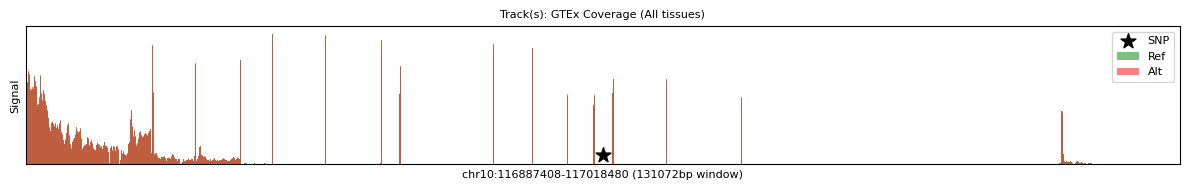

 - sum_wt = 43400.965
 - sum_mut = 53960.77
 - max_y_wt = 339.3114
 - max_y_mut = 423.4269
 -- (max_y = 423.4269)


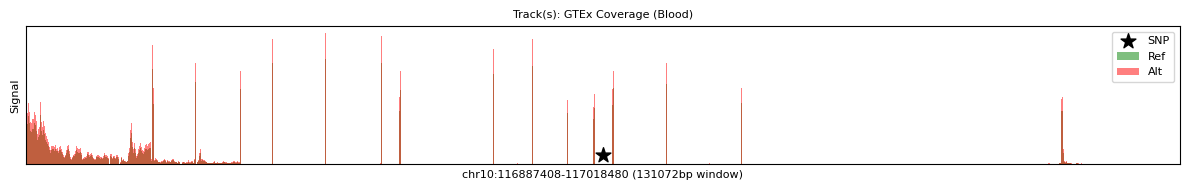

 - sum_wt = 32183.568
 - sum_mut = 33052.17
 - max_y_wt = 296.1789
 - max_y_mut = 302.3407
 -- (max_y = 302.3407)


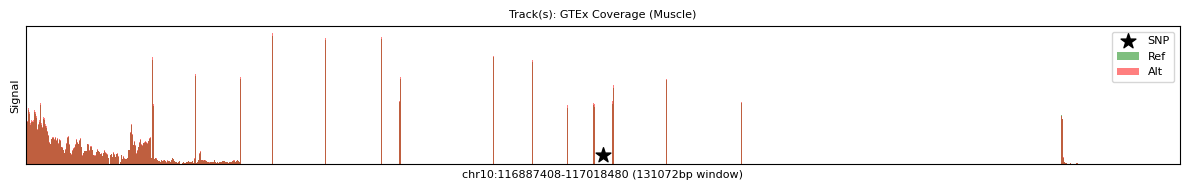

In [6]:
#Predict for chr10_116952944_T_C

save_figs = False
save_suffix = '_chr10_116952944_T_C'

sequence_one_hot_wt = process_sequence(fasta_open, chrom, start, end)

#Induce mutation(s)
sequence_one_hot_mut = np.copy(sequence_one_hot_wt)

for pos, alt in zip(poses, alts) :
    alt_ix = -1
    if alt == 'A' :
        alt_ix = 0
    elif alt == 'C' :
        alt_ix = 1
    elif alt == 'G' :
        alt_ix = 2
    elif alt == 'T' :
        alt_ix = 3

    sequence_one_hot_mut[pos-start-1] = 0.
    sequence_one_hot_mut[pos-start-1, alt_ix] = 1.

#Make predictions
y_wt = predict_tracks(models, sequence_one_hot_wt)
y_mut = predict_tracks(models, sequence_one_hot_mut)

#Visualize quantized tracks over SNP

plot_window = 131072
bin_size = 32
pad = 16

rescale_tracks = True
normalize_counts = False

anno_df = None #splice_df

#Tracks
track_indices = [
    np.arange(0, 89).tolist(),
    [9, 10, 11],
    [47, 48, 49],
]

track_names = [
    'GTEx Coverage (All tissues)',
    'GTEx Coverage (Blood)',
    'GTEx Coverage (Muscle)',
]

track_scales = [
    0.01,
    0.01,
    0.01,
]

track_transforms = [
    3./4.,
    3./4.,
    3./4.,
]

soft_clips = [
    384.,
    384.,
    384.,
]

print("-- Counts --")
plot_coverage_track_pair_bins(y_wt, y_mut, chrom, start, center_pos, poses, track_indices, track_names, track_scales, track_transforms, soft_clips, plot_window=plot_window, normalize_window=1*plot_window, bin_size=bin_size, pad=pad, rescale_tracks=rescale_tracks, normalize_counts=normalize_counts, save_figs=save_figs, save_suffix=save_suffix, gene_slice=gene_slice, anno_df=anno_df)


In [ ]:
#Get contribution scores (gradient) for blood GTEX tracks

_, _, [pred_grad_wt, pred_grad_mut] = get_prediction_gradient_w_rc(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    0,
    1,
    0,
    1,
    target_index[[9, 10, 11]].tolist(),
    0.01,
    3./4.,
    clip_soft=384.,
    dist_bin_index=gene_slice.tolist(),
    use_mean=False,
    use_ratio=False,
    use_logodds=False,
    subtract_avg=True,
    fold_index=[0, 1, 2, 3],
)


--- WT ---


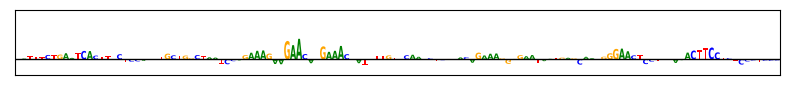

--- Mut ---


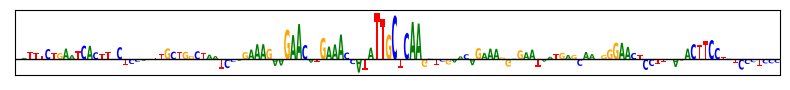

In [11]:
#Visualize contribution scores

visualize_input_gradient_pair(
    pred_grad_wt,
    pred_grad_mut,
    plot_start=(poses[0] - start) - 64,
    plot_end=(poses[0] - start) + 64,
    save_figs=True,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_grad_gtex_snp_4_folds_gtex_blood_cov_undo_clip'
)


In [ ]:
#Get contribution scores (ISM) for blood GTEX tracks

[pred_ism_wt, pred_ism_mut] = get_ism(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    (poses[0] - start) - 64,
    (poses[0] - start) + 64,
    0,
    1,
    0,
    1,
    [9, 10, 11],
    0.01,
    3./4.,
    384.,
    dist_bin_index=gene_slice.tolist(),
    use_mean=True,
    use_ratio=False,
    use_logodds=False,
)


--- WT ---


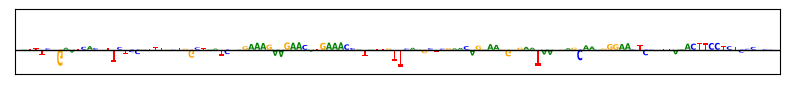

--- Mut ---


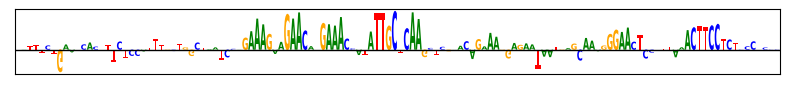

In [13]:
#Visualize contribution scores

visualize_input_gradient_pair(
    pred_ism_wt,
    pred_ism_mut,
    plot_start=(poses[0] - start) - 64,
    plot_end=(poses[0] - start) + 64,
    save_figs=True,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_ism_gtex_snp_4_folds_gtex_blood_cov_undo_clip'
)


In [ ]:
#Get contribution scores (ISM shuffle) for blood GTEX tracks

[pred_ism_wt, pred_ism_mut] = get_ism_shuffle(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    (poses[0] - start) - 64,
    (poses[0] - start) + 64,
    0,
    1,
    0,
    1,
    [9, 10, 11],
    0.01,
    3./4.,
    384.,
    window_size=7,
    n_samples=24,
    dinuc_shuffle=True,
    dist_bin_index=gene_slice.tolist(),
    use_mean=True,
    use_ratio=False,
    use_logodds=False,
)


--- WT ---


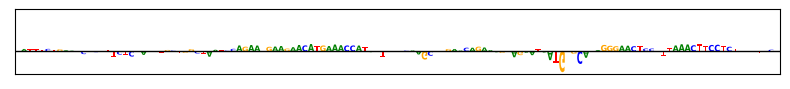

--- Mut ---


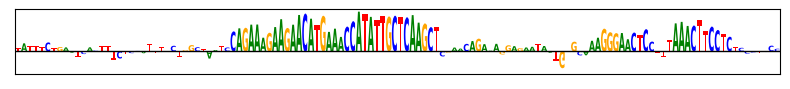

In [15]:
#Visualize contribution scores

visualize_input_gradient_pair(
    pred_ism_wt,
    pred_ism_mut,
    plot_start=(poses[0] - start) - 64,
    plot_end=(poses[0] - start) + 64,
    save_figs=True,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_ism_shuffle_gtex_snp_4_folds_gtex_blood_cov_undo_clip'
)


In [12]:
#Load samples with reference- and alternate alleles respectively

#These files are protected by dbGaP - email to request access

cov_files_wt = pd.read_csv("gtex_ref_chr10_116952944_T_C.txt", sep='\t', names=['file'])['file'].values.tolist()
cov_files_mut = pd.read_csv("gtex_alt_chr10_116952944_T_C.txt", sep='\t', names=['file'])['file'].values.tolist()


gtex_targets_wt.shape = (16352, 32)
gtex_targets_mut.shape = (16352, 32)
-- Counts --
 - sum_wt = 27668.607
 - sum_mut = 37653.69
 - max_y_wt = 241.0508
 - max_y_mut = 370.9016
 -- (max_y = 370.9016)


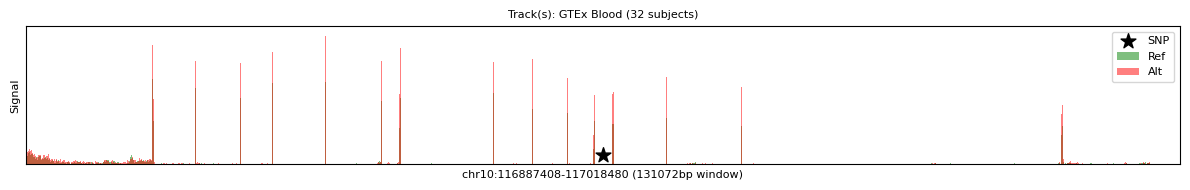

In [13]:
#Visualize measured coverage tracks for chr10_116952944_T_C

save_figs = False
save_suffix = '_chr10_116952944_T_C_meas_32_subjects'

center_pos = 116952944

chrom = 'chr10'
poses = [116952944]
alts = ['C']

start = center_pos - seq_len // 2
end = center_pos + seq_len // 2

blacklist_bed = "/home/drk/common/data/genomes/hg38/blacklist/blacklist_hg38_all.bed"

read_coverage_func_wt, close_coverage_func_wt = get_coverage_reader(cov_files_wt, 16384, 16, blacklist_bed)
read_coverage_func_mut, close_coverage_func_mut = get_coverage_reader(cov_files_mut, 16384, 16, blacklist_bed)

gtex_targets_wt = read_coverage_func_wt(chrom, start, end, clip_soft=384., clip=768., scale=0.01)
gtex_targets_mut = read_coverage_func_mut(chrom, start, end, clip_soft=384., clip=768., scale=0.01)

close_coverage_func_wt()
close_coverage_func_mut()

print("gtex_targets_wt.shape = " + str(gtex_targets_wt.shape))
print("gtex_targets_mut.shape = " + str(gtex_targets_mut.shape))

plot_window = 131072
bin_size = 32
pad = 16

anno_df = None #splice_df

rescale_tracks = True
normalize_counts = True

#Tracks
track_indices = [
    np.arange(32).tolist(),
]

track_names = [
    'GTEx Blood (32 subjects)',
]

track_scales = [
    0.01,
]

track_transforms = [
    3./4.,
]

soft_clips = [
    384.,
]

print("-- Counts --")
plot_coverage_track_pair_bins(gtex_targets_wt[None, None, ...], gtex_targets_mut[None, None, ...], chrom, start, center_pos, poses, track_indices, track_names, track_scales, track_transforms, soft_clips, plot_window=plot_window, normalize_window=4*plot_window, bin_size=bin_size, pad=pad, rescale_tracks=rescale_tracks, normalize_counts=normalize_counts, save_figs=save_figs, save_suffix=save_suffix, gene_slice=gene_slice, anno_df=anno_df)
